In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [171]:
data = pd.read_csv('input_data_10.csv')

In [172]:
data.head(3)

,task_id,receipt_id,supplier_id,product_id,sku_name,sku_weight_kg,sku_volume_litr,sku_type,planned_quantity,accepted_quantity,planned_weight_kg,accepted_weight_kg,accepted_volume_litr,started_at,finished_at,inbnd_duration_min
0,c803143d-f9ba-4eab-969c-7ed4d3c87021,1003768954,29812d04-eccd-11e8-80c5-0cc47a817925,1738eae4-1efb-11ed-b96c-08c0eb32008b,"Фрикадельки Мираторг Традиционные свиные, говя...",0.258,1.19700,piece,24.0,24.0,6.192,6.192,28.7280,2025-07-09 09:36:28.045,2025-07-09 09:47:30.221,11.036275
1,ea068993-ab6f-4b81-81e0-08605c22c4c2,1003769128,29812d04-eccd-11e8-80c5-0cc47a817925,1738eae4-1efb-11ed-b96c-08c0eb32008b,"Фрикадельки Мираторг Традиционные свиные, говя...",0.258,1.19700,piece,16.0,16.0,4.128,4.128,19.1520,2025-07-10 12:21:08.970,2025-07-10 12:27:14.467,6.091615
2,da731ba4-2944-492e-b282-9a9c89a4d682,1003759180,c7a48c69-0381-11e9-80c5-0cc47a817925,33eae969-fa98-11e8-80c5-0cc47a817925,"Творожок Даниссимо с изысканным шоколадом, 6,7...",0.139,0.34132,piece,120.0,120.0,16.680,16.680,40.9584,2025-07-03 15:13:51.271,2025-07-03 16:15:46.433,61.919370


### Data discovery

<Axes: >

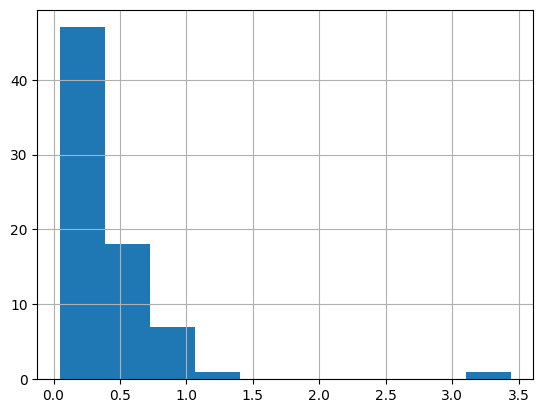

In [173]:
product_data = data.copy()
product_data = product_data[product_data['product_id']=='1738eae4-1efb-11ed-b96c-08c0eb32008b']
product_data = product_data[['inbnd_duration_min','accepted_quantity']]
product_data['item_inbnd_duration_min'] = product_data['inbnd_duration_min']/product_data['accepted_quantity']
product_data['item_inbnd_duration_min'].hist()

### Преобразование данных

In [174]:
df = data.copy()

In [175]:
len(df)

35681

In [176]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['finished_at'] = pd.to_datetime(df['finished_at'])
df['hour'] = df['started_at'].dt.hour.astype(str)
df['day_of_week'] = df['started_at'].dt.dayofweek.astype(str)
df['month'] = df['started_at'].dt.month.astype(str)
df['day'] = df['started_at'].dt.day.astype(str)

In [177]:
def handle_missing_data(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col].fillna('Unknown', inplace=True)
    
    return df

In [178]:
def encode_categorical_features(df):
    le = LabelEncoder()
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    
    return df

In [179]:
df = handle_missing_data(df)
df = encode_categorical_features(df)

In [180]:
x = df.drop(['sku_name',
             'receipt_id',
             'task_id',
             'sku_type',
             'accepted_quantity',
             'accepted_weight_kg',
             'accepted_volume_litr',
            'started_at',
            'finished_at',
            'inbnd_duration_min'], axis=1)
y = df['inbnd_duration_min']

In [181]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

## Обучение модели

In [182]:
# 5. МАСШТАБИРОВАНИЕ ЧИСЛОВЫХ ПРИЗНАКОВ (опционально для LightGBM, но может помочь)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [183]:
params = {
    'boosting_type': 'gbdt',          # тип бустинга
    'objective': 'regression',        # задача регрессии
    'metric': 'mae',                  # метрика - средняя абсолютная ошибка
    'num_leaves': 31,                 # максимальное количество листьев в дереве
    'learning_rate': 0.05,            # скорость обучения
    'feature_fraction': 0.9,          # доля признаков для использования на каждой итерации
    'bagging_fraction': 0.8,          # доля данных для использования на каждой итерации
    'bagging_freq': 5,                # частота bagging
    'verbose': 0,                     # уровень детализации вывода
    'random_state': 42,               # для воспроизводимости
    'n_estimators': 1000,             # количество деревьев
    'max_depth': -1,                  # глубина деревьев (-1 = без ограничений)
    'min_data_in_leaf': 20,           # минимальное количество данных в листе
}

In [184]:
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

In [185]:
# Обучение модели с ранней остановкой
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 13.6976
[200]	valid_0's l1: 11.4127
[300]	valid_0's l1: 9.93532
[400]	valid_0's l1: 9.05084
[500]	valid_0's l1: 8.43879
[600]	valid_0's l1: 7.97076
[700]	valid_0's l1: 7.64693
[800]	valid_0's l1: 7.40252
[900]	valid_0's l1: 7.14084
[1000]	valid_0's l1: 6.91075
Did not meet early stopping. Best iteration is:
[998]	valid_0's l1: 6.91059


In [186]:
y_pred = model.predict(X_test_scaled)

In [187]:
# Метрики качества
print("\n" + "="*50)
print("ОЦЕНКА КАЧЕСТВА МОДЕЛИ")
print("="*50)
print(f"MAE (Средняя абсолютная ошибка): {mean_absolute_error(y_test, y_pred):.2f} минут")
print(f"MSE (Средняя квадратичная ошибка): {mean_squared_error(y_test, y_pred):.2f}")
print(f"RMSE (Корень из MSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} минут")
print(f"R² (Коэффициент детерминации): {r2_score(y_test, y_pred):.4f}")


ОЦЕНКА КАЧЕСТВА МОДЕЛИ
MAE (Средняя абсолютная ошибка): 6.91 минут
MSE (Средняя квадратичная ошибка): 113.35
RMSE (Корень из MSE): 10.65 минут
R² (Коэффициент детерминации): 0.9380


## Важность признаков

In [188]:
# 8. ВАЖНОСТЬ ПРИЗНАКОВ
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)

print("\nТОП-15 ВАЖНЕЙШИХ ПРИЗНАКОВ:")
print(feature_importance.head(15))


ТОП-15 ВАЖНЕЙШИХ ПРИЗНАКОВ:
             feature  importance
0        supplier_id        5846
9                day        5825
6               hour        3768
7        day_of_week        2837
2      sku_weight_kg        2507
3    sku_volume_litr        2427
4   planned_quantity        1783
5  planned_weight_kg        1715
1         product_id        1654
8              month        1578


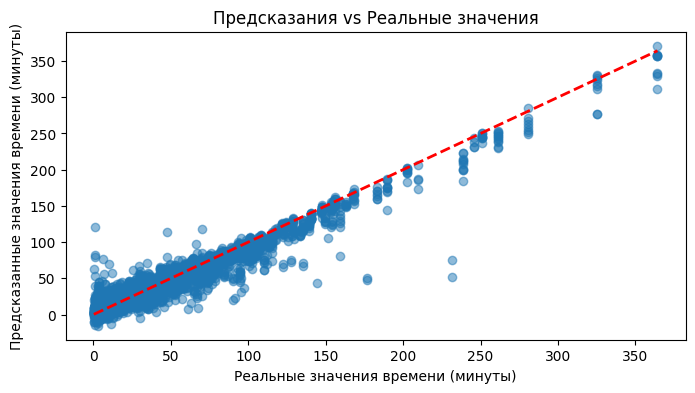

In [189]:
# 9. ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ vs РЕАЛЬНЫЕ ЗНАЧЕНИЯ
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальные значения времени (минуты)')
plt.ylabel('Предсказанные значения времени (минуты)')
plt.title('Предсказания vs Реальные значения')
plt.show()

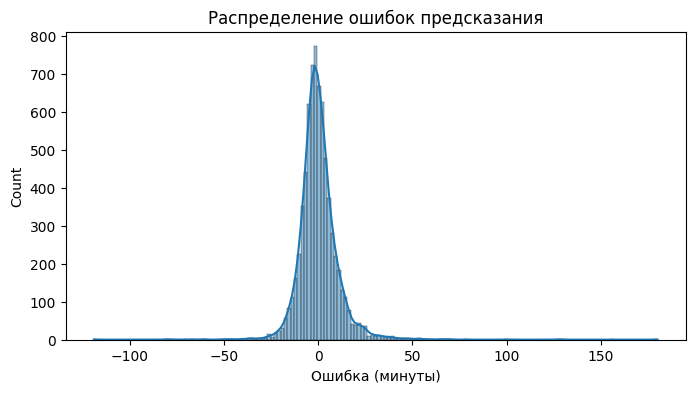

In [190]:
# 10. АНАЛИЗ ОШИБОК
errors = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True)
plt.title('Распределение ошибок предсказания')
plt.xlabel('Ошибка (минуты)')
plt.show()

In [191]:
# Создаем DataFrame с результатами
results_df = x_test.copy()

# Добавляем предсказания и фактические значения
results_df['predicted_time'] = y_pred
results_df['actual_time'] = y_test

# Вычисляем ошибку
results_df['error'] = results_df['actual_time'] - results_df['predicted_time']
results_df['absolute_error'] = abs(results_df['error'])

# Сохраняем в CSV
results_df.to_csv('predictions_results.csv', index=False, encoding='utf-8-sig')

print("Файл сохранен: predictions_results.csv")
print(f"Количество строк: {len(results_df)}")
print(f"Средняя ошибка: {results_df['absolute_error'].mean():.2f} минут")

Файл сохранен: predictions_results.csv
Количество строк: 7137
Средняя ошибка: 6.91 минут
